# Risk of infection amongst royal papworth hospital staff
Steensels et al. found no influence of age or sex on presence of antibodies in staff. I suspect that the most likely important variables are work location and classification.

Sero positives and negatives are based on the linear SVM trained on known positive and negative cases.

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

%load_ext rpy2.ipython
from rpy2.robjects import r

In [2]:
%%R
packages <- c("ggplot2", "dplyr", "diosR", "plot.matrix", "broom", "dotwhisker", "MuMIn")
lapply(packages, require, character.only=T)

/home/david/miniconda3/envs/HICC_datapipe/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/home/david/miniconda3/envs/HICC_datapipe/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: dplyr

  warnings.warn(x, RRuntimeWarning)
/home/david/miniconda3/envs/HICC_datapipe/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/david/miniconda3/envs/HICC_datapipe/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/david/miniconda3/envs/HICC_datapipe/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, seteq

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] FALSE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] FALSE

[[7]]
[1] TRUE



In [3]:
os.chdir("/home/david/linux_work/coronavirus_2020/papworth/staff_analysis/data")

In [4]:
%%R
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/david/miniconda3/envs/HICC_datapipe/lib/libmkl_rt.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] MuMIn_1.43.17     broom_0.5.2       plot.matrix_1.5.2 dplyr_1.0.2      
[5] ggplot2_3.3.3    

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.5       magrittr_1.5     tidyselect_1.1.0 munsell_0.5.0   
 [5] colorspace_1.4-1 lattice_0.20-38  R6_2.4.0         rlang_0.4.10    
 [9] grid_3.6.1       gtable_0.3.0     nlme_3.1-139     with

# Preprocessing

In [5]:
%%R
staf <- read.csv('staff_svm_demographic_antibodies.csv')

In [6]:
%%R
#Set missing sex data to NA
levels(staf$sex)[which(levels(staf$sex)=="")] <- NA
levels(staf$nep)[which(levels(staf$nep)=="")] <- NA

In [7]:
%%R
#Set severity, ethnicity, jobtype, and location to factors
staf$severity <- as.factor(staf$severity)
staf$ethnicity <- as.factor(staf$ethnicity)
staf$jobtype <- as.factor(staf$jobtype)
staf$location <- as.factor(staf$location)
staf$location <- relevel(staf$location, ref="3")

In [8]:
%%R
str(staf)

'data.frame':	500 obs. of  23 variables:
 $ id              : Factor w/ 500 levels "staff1","staff10",..: 1 112 223 334 445 457 479 468 490 2 ...
 $ laminar         : num  NA NA NA 2 NA NA NA NA NA NA ...
 $ age             : num  NA 42 NA 39 53 42 40 55 31 51 ...
 $ sex             : Factor w/ 2 levels "f","m": 2 1 1 1 2 1 1 2 2 2 ...
 $ severity        : Factor w/ 4 levels "1","2","3","4": 2 2 1 3 2 1 3 2 NA 1 ...
 $ ethnicity       : Factor w/ 5 levels "1","2","3","4",..: 3 1 1 1 1 1 3 1 1 1 ...
 $ jobtype         : Factor w/ 2 levels "1","2": 1 1 1 1 1 1 1 1 1 1 ...
 $ location        : Factor w/ 3 levels "3","1","2": 2 3 3 3 3 3 1 3 3 3 ...
 $ note            : Factor w/ 2 levels ""," (re-assigned at sampling from 110)": 1 1 1 1 1 1 1 1 1 1 ...
 $ BOOKED.ON.EPIC  : Factor w/ 2 levels "","Y": 2 2 2 2 2 2 2 2 2 2 ...
 $ DATE.TESTED     : Factor w/ 19 levels "","01/05/2020",..: 12 10 10 10 10 10 10 18 19 19 ...
 $ BATCH           : Factor w/ 24 levels "","ICDV3","ICDV9",..: 6 16 16 1

In [9]:
# %%R
# #E is Positive
# staf$ep <- staf$nep %in% c('E', 'P')

# #E is Neagative
# staf$en <- staf$nep == 'P'

# #Custom seropositive cut off of N > 14900
# staf$ncut <- staf$n > 14900

In [10]:
%%R
#Remove samples with mey missing data
stafn <- staf[!is.na(staf$sero_svm) & !is.na(staf$location),]

# Exploration plots
Job type and location are clearly closely linked and likely be colinear, taking variance out of each other. Therefore, only one of these two should be included in a model. I favour location simply because it has more levels (both larger than the admin/non-patient groups).

In [11]:
%%R
#Counts of sero status by staff location
# work location: 1=patient facing critical care; 2= patient facing non-critical care; 3 = nonpatient facing
print(table(stafn$location, stafn$sero_svm))

# Proportion of staff in that location with serostatus negative or positive
round(
    prop.table(table(stafn$location, stafn$sero_svm), 1),
    2
)

   
      0   1
  3  47  13
  1 115  11
  2 241  41
   
       0    1
  3 0.78 0.22
  1 0.91 0.09
  2 0.85 0.15


In [12]:
%%R
print(table(staf$sero_svm))
#Proportion of staff classified as seronegative or seropositive
prop.table(table(stafn$sero_svm))


  0   1 
423  70 

        0         1 
0.8611111 0.1388889 


In [13]:
%%R
# Median age
median(stafn$age, na.rm=T)

[1] 41


In [14]:
%%R
# Gender proportions
prop.table(table(stafn$sex))


        f         m 
0.6984127 0.3015873 


In [15]:
%%R

# Gender proportions
#ethicity 1=white; 2=mixed, 3=asian, 4=black, 5 =other

round(
    prop.table(table(stafn$ethnic)),
      2)


   1    2    3    4    5 
0.79 0.03 0.16 0.02 0.00 


In [16]:
%%R
#Proportion of staff in different locations
# work location: 1=patient facing critical care; 2= patient facing non-critical care; 3 = nonpatient facing
prop.table(table(
    stafn$location
))


        3         1         2 
0.1282051 0.2692308 0.6025641 


Data for table 1

In [17]:
%%R
#Staff sero status
stafn$sero_svm %>% table

.
  0   1 
403  65 


In [18]:
%%R
#Staff sex and serostatus
table(stafn$sex, stafn$sero_svm) %>% print
prop.table(table(stafn$sex, stafn$sero_svm), margin=1) %>% print

#Number of staff with NA for sex
sum(is.na(stafn$sex))

   
      0   1
  f 263  45
  m 118  15
   
            0         1
  f 0.8538961 0.1461039
  m 0.8872180 0.1127820
[1] 27


In [19]:
%%R
# Staff ethnicity and serostatus
table(stafn$ethnic, stafn$sero_svm) %>% print
prop.table(table(stafn$ethnic, stafn$sero_svm), margin=1) %>% print
sum(is.na(stafn$ethnic))

   
      0   1
  1 322  46
  2  11   4
  3  59  13
  4   6   2
  5   1   0
   
            0         1
  1 0.8750000 0.1250000
  2 0.7333333 0.2666667
  3 0.8194444 0.1805556
  4 0.7500000 0.2500000
  5 1.0000000 0.0000000
[1] 4


In [20]:
%%R
# Staff location and serostatus
# work location: 1=patient facing critical care; 2= patient facing non-critical care; 3 = nonpatient facing

table(stafn$location, stafn$sero_svm) %>% print
prop.table(table(stafn$location, stafn$sero_svm), margin=1) %>% print
sum(is.na(stafn$location))

   
      0   1
  3  47  13
  1 115  11
  2 241  41
   
             0          1
  3 0.78333333 0.21666667
  1 0.91269841 0.08730159
  2 0.85460993 0.14539007
[1] 0


In [21]:
41+241

282

# Fit models
Initially lets use Rainer's categorisation but try with E as positive and negative, and dropping them.

In [22]:
# %%R
# #NO E nep in model
# noe1 <- glm(nep ~ location + jobtype, data=stafn[stafn$nep!="E",], family="binomial")
# noe2 <- glm(nep ~ location + jobtype, data=stafn[stafn$nep!="E",], family="binomial")
# noe3 <- glm(nep ~ location, data=stafn[stafn$nep!="E",], family="binomial")

# AIC(noe1,noe2,noe3)

In [23]:
# %%R
# noe4 <- glm(nep ~ jobtype, data=stafn[stafn$nep!="E",], family="binomial")
# dwplot(list(noe1,noe2,noe3, noe4))+
# geom_vline(xintercept=0, lty=2)+
# theme_dios()

In [24]:
%%R

# # Using our N only cutoff
# ncut1 <- glm(ncut ~ location * jobtype, data=stafn, family="binomial")
# ncut2 <- glm(ncut ~ location + jobtype, data=stafn, family="binomial")
# ncut3 <- glm(ncut ~ location, data=stafn, family="binomial")

# Using the svm cut off
ncut0 <- glm(sero_svm ~ 1, data=stafn, family="binomial")
# ncut1 <- glm(sero_svm ~ location * jobtype, data=stafn, family="binomial")
# ncut2 <- glm(sero_svm ~ location + jobtype, data=stafn, family="binomial")
ncut3 <- glm(sero_svm ~ location, data=stafn, family="binomial")


print(AICc(ncut0,ncut3))
summary(ncut3)

      df     AICc
ncut0  1 379.1617
ncut3  3 377.2760

Call:
glm(formula = sero_svm ~ location, family = "binomial", data = stafn)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6988  -0.5605  -0.5605  -0.4274   2.2083  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.2852     0.3134  -4.101 4.11e-05 ***
location1    -1.0618     0.4448  -2.387    0.017 *  
location2    -0.4860     0.3560  -1.365    0.172    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 377.15  on 467  degrees of freedom
Residual deviance: 371.22  on 465  degrees of freedom
AIC: 377.22

Number of Fisher Scoring iterations: 5



In [25]:
%%R
summary(ncut3)$coefficients

              Estimate Std. Error   z value     Pr(>|z|)
(Intercept) -1.2851982  0.3133683 -4.101239 4.109434e-05
location1   -1.0618386  0.4447521 -2.387484 1.696412e-02
location2   -0.4860266  0.3560046 -1.365226 1.721822e-01


In [26]:
%%R
nrow(model.matrix(ncut3))

[1] 468


In [27]:
%%R
#Model validation

# plot(ncut3)

NULL


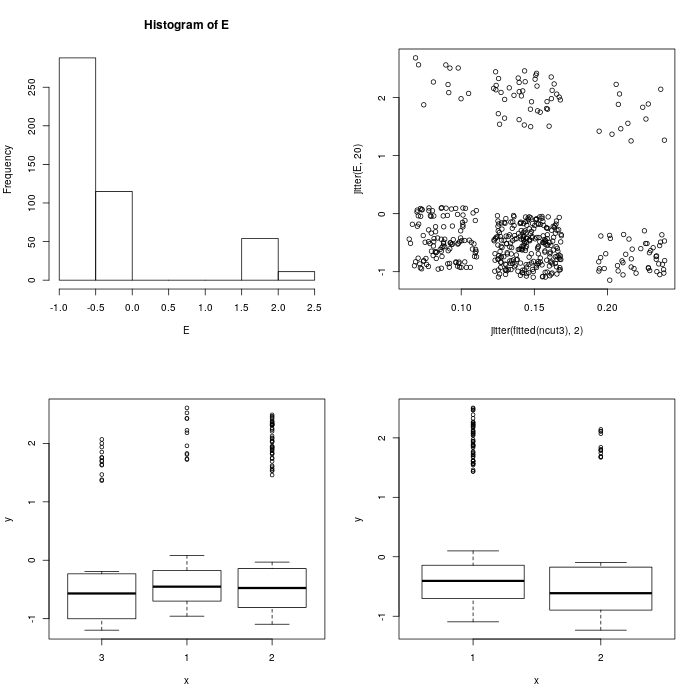

In [28]:
%%R -w 700 -h 700
op <- par()
par(mfrow=(c(2,2)))

E <- resid(ncut3)

hist(E)
plot(jitter(fitted(ncut3),2),jitter(E,20))
plot(stafn$location, jitter(E,20))
plot(stafn$jobtype, jitter(E,20))

par(op)

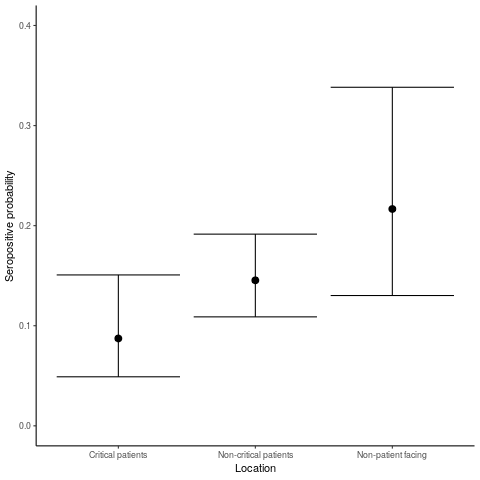

In [29]:
%%R
nd <- data.frame(location=levels(staf$location))
nd <- cbind(nd, predict(ncut3, newdata=nd, se.fit=T))

fig <- 
ggplot(nd, aes(x=location, y=plogis(fit))) +
geom_errorbar(aes(ymin=plogis(fit-(1.96*se.fit)), ymax=plogis(fit+(1.96*se.fit))))+
geom_point(size=3)+
xlab("Location")+
ylab("Seropositive probability")+
ylim(c(0,0.4))+
scale_x_discrete(labels=c('Critical patients', "Non-critical patients", "Non-patient facing"))+
# theme_dios()
theme_classic()

fig

In [30]:
%%R
# ggsave("figure location FX.jpg", fig, dpi=300)

NULL


`summarise()` ungrouping output (override with `.groups` argument)


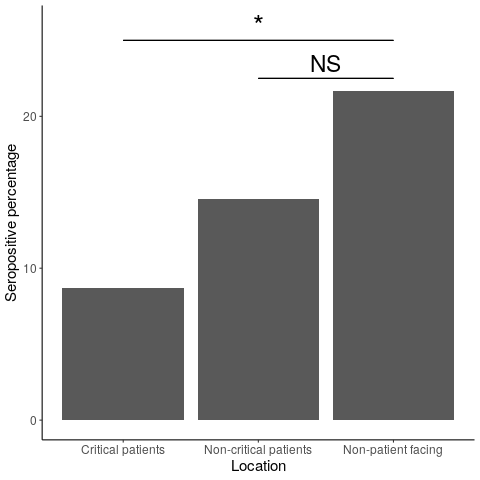

In [35]:
%%R
stafnsum <- summarise(group_by(stafn, location), 
                      sero_n=sum(sero_svm==0), 
                      sero_p=sum(sero_svm==1),
                      n=n(), propP=mean(sero_svm))
stafnsum$percP <- stafnsum$propP*100

levels(stafnsum$location) <- c("Non-patient facing","Critical patients", "Non-critical patients")

fig <-
ggplot(stafnsum, aes(x=location, y=percP))+
geom_bar(stat="identity")+
geom_segment(aes(x=1, xend=3, y=25, yend=25))+
annotate(geom="text",x=2, y=26, label="*", size=10)+
geom_segment(aes(x=2, xend=3, y=22.5, yend=22.5))+
annotate(geom="text",x=2.5, y=23.5, label="NS", size=8)+
scale_x_discrete(limits=c("Critical patients", "Non-critical patients", "Non-patient facing"))+
ylab("Seropositive percentage")+
xlab("Location")+
theme_classic()+
theme(text=element_text(size=15))

fig

In [36]:
%%R
# ggsave("figure2.jpg", fig, dpi=300)
# write.csv(stafnsum, "location_proportions.csv", row.names=F)

/home/david/miniconda3/envs/HICC_datapipe/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Saving 6.67 x 6.67 in image

  warnings.warn(x, RRuntimeWarning)


## Add ethnicity

In [22]:
%%R
# Using the svm cut off
e0 <- glm(sero_svm ~ 1, data=filter(stafn, ethnicity %in% c(1,3)), family="binomial")
e1 <- glm(sero_svm ~ ethnicity, data=filter(stafn, ethnicity %in% c(1,3)), family="binomial")
e2 <- glm(sero_svm ~ location, data=filter(stafn, ethnicity %in% c(1,3)), family="binomial")
e3 <- glm(sero_svm ~ location + ethnicity, data=filter(stafn, ethnicity %in% c(1,3)), family="binomial")
e4 <- glm(sero_svm ~ location * ethnicity, data=filter(stafn, ethnicity %in% c(1,3)), family="binomial")

AICc(e0,e1,e2,e3, e4)

   df     AICc
e0  1 348.8083
e1  2 349.3321
e2  3 345.2673
e3  4 345.2349
e4  6 346.9954


In [23]:
%%R
Weights(AICc(e0,e1,e2,e3, e4))

 model weights 
[1] 0.062 0.048 0.365 0.371 0.154


In [24]:
%%R
summary(e3)


Call:
glm(formula = sero_svm ~ location + ethnicity, family = "binomial", 
    data = filter(stafn, ethnicity %in% c(1, 3)))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8567  -0.5291  -0.5291  -0.3720   2.3260  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.3331     0.3193  -4.176 2.97e-05 ***
location1    -1.3028     0.4711  -2.766  0.00568 ** 
location2    -0.5626     0.3625  -1.552  0.12062    
ethnicity3    0.5198     0.3502   1.484  0.13771    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 346.80  on 439  degrees of freedom
Residual deviance: 337.14  on 436  degrees of freedom
AIC: 345.14

Number of Fisher Scoring iterations: 5



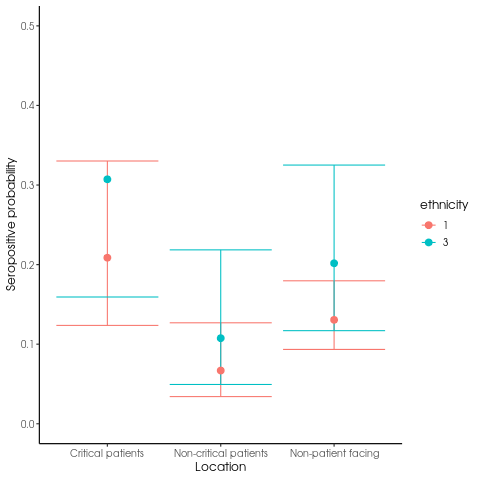

In [25]:
%%R
nd <- data.frame(expand.grid(location=levels(staf$location), ethnicity=as.factor(c(1,3))))
nd <- cbind(nd, predict(e3, newdata=nd, se.fit=T))

ggplot(nd, aes(x=location, y=plogis(fit), colour=ethnicity)) +
geom_errorbar(aes(ymin=plogis(fit-(1.96*se.fit)), ymax=plogis(fit+(1.96*se.fit))))+
geom_point(size=3)+
xlab("Location")+
ylab("Seropositive probability")+
ylim(c(0,0.5))+
scale_x_discrete(labels=c('Critical patients', "Non-critical patients", "Non-patient facing"))+
theme_dios()

UsageError: Cell magic `%%R` not found.
